In [1]:
#Install required packages

%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("MODEL")                  # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")

In [3]:
# Multi-Agent Orchestration with LangGraph:
#- Supervisor agent coordinates between specialized workers.
#- Workers: weather reporting agent, dressing planner agent.
#- State management and dynamic worker routing based on conversation flow.

# ---- Imports ----

import os
import json
from typing import Literal, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import interrupt, Command
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import display, Image

# ---- LLM Setup ----

# Load the default model from environment variables
default_model = os.environ["MODEL"]

# Initialize the LLM (Large Language Model) interface
llm = ChatOpenAI(model=default_model)

# ---- Supervisor Setup ----

# Define agent members
members = ["weather_reporting", "dressing_planer"]

# Supervisor options include all members + END signal
options = members + [END]

# System prompt guiding the supervisor's behavior
system_prompt = (
    "# Role and Objective"
    "You are a Supervisor Agent tasked with managing a conversation between two specialized workers: `weather_reporting` and `dressing_planner`."
    "Your goal is to orchestrate their actions to resolve the user's request efficiently."
    "# Instructions"
    f"- Persist through multiple steps until the task is fully complete. Only output {END} when finished."
    "- Always select the next worker based on context."
    "- Think step-by-step before choosing a worker and after receiving results."
    "# Reasoning Steps"
    "1. Analyze current state."
    "2. Plan the next best action."
    "3. Reflect after worker output."
    "4. Repeat until completion."
    "5. End cleanly with {END}."
    "# Tool/Worker Use"
    "- `weather_reporting`: gather or analyze weather."
    "- `dressing_planner`: suggest clothing based on weather."
)

class Router(TypedDict):
    """Defines the next worker or signals END."""
    next: Literal[*options]

class State(MessagesState):
    """Extended state tracking next agent selection."""
    next: str

# ---- Node Definitions ----

def supervisor_node(state: State) -> Command[Literal[*members, END]]:
    """Supervisor agent logic to pick next worker."""
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    return Command(goto=goto, update={"next": goto})
  

In [4]:
# ---- Worker Agents ----

@tool
def weather_reporting_tool(city: Annotated[str, "name of the city"]):
    """Tool to fetch current weather data for a given city."""
    try:
        # (Simulated API call — replace with real API integration)
        json_data = {
            "weather": {
                "name": city,
                "main": "Rain",
                "description": "moderate rain",
                "temp": 284.2,
                "feels_like": 282.93,
                "temp_min": 283.06,
                "temp_max": 286.82,
                "pressure": 1021,
                "humidity": 60,
                "sea_level": 1021,
                "grnd_level": 910
            }
        }
        return json_data
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"

# Weather Reporting Agent
weather_reporting_agent = create_react_agent(
    llm,
    tools=[weather_reporting_tool],
    name="weather_reporting_agent",
    prompt=(
        "You are a weather reporter. Report current weather for the provided city. "
        "You may use tools. Do not suggest what to wear."
    )
)

def weather_reporting_node(state: State) -> Command[Literal["supervisor"]]:
    """Node to execute weather reporting."""
    result = weather_reporting_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="weather_reporting")
            ]
        },
        goto="supervisor",
    )

# Dressing Planner Agent
dressing_planer_agent = create_react_agent(
    llm,
    tools=[],
    name="dressing_planer_agent",
    prompt=(
        "You suggest dressing options based on the current weather. "
        "Prioritize 'feels like' temperature and consider wind conditions."
    )
)

def dressing_planer_node(state: State) -> Command[Literal["supervisor"]]:
    """Node to execute dressing planning based on weather."""
    result = dressing_planer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="dressing_planer")
            ]
        },
        goto="supervisor",
    )



In [7]:
# ---- Graph Assembly ----

# Create the state graph
builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("weather_reporting", weather_reporting_node)
builder.add_node("dressing_planer", dressing_planer_node)

# Checkpointer to persist states in memory
checkpointer = MemorySaver()

# Compile the graph
graph = builder.compile(checkpointer=checkpointer)


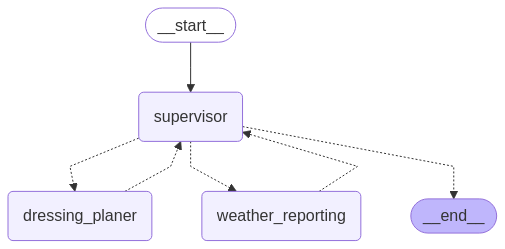

In [8]:
# ---- Visualize ----

# Display the compiled agent graph using Mermaid (rendered as PNG)
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# ---- Simulation ----

# Configuration for conversation session
config = {"configurable": {"thread_id": "1"}}

# Start conversation (Turn 1)
for s in graph.stream(
    {"messages": [("user", "What is the current temperature in Stockholm?")]}, subgraphs=True,debug=True, config=config):
    print(s)
    print("============================")

# Ask a followup question (Turn 2)
for s in graph.stream(
    {"messages": [("user", "Do you suggest carrying an umbrella with me?")]}, subgraphs=True,debug=True, config=config):
    print(s)
    print("============================")

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user', 'What is the current temperature in Stockholm?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user', 'What is the current temperature in Stockholm?')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='What is the current temperature in Stockholm?', additional_kwargs={}, response_metadata={}, id='74a36f60-553a-4da1-8bd9-1c93b0b7096e')]}
[1:tasks] Starting 1 task for step 1:
- supervisor -> {'messages': [HumanMessage(content='What is the current temperature in Stockholm?', additional_kwargs={}, response_metadata={}, id='74a36f60-553a-4da1-8bd9-1c93b0b7096e')]}
((), {'supervisor': {'next': 'weather_reporting'}})
[1:writes] Finished step 1 with writes to 1 channel:
- next -> 'weather_reporting'
[1:checkpoint] State at the end of step 1:
{'messages': [HumanMessage(content='What is the current tempera